In [194]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np

In [195]:
train = pd.read_csv('Dataset/Train.csv')
test = pd.read_csv('Dataset/Test.csv')

In [196]:
df=train.copy(deep=True)

In [197]:
df.head()

,Date,Open,High,Low,Close,Volume,Name,Trading
0,2006-01-03,77.76,79.35,77.24,79.11,3117200,MMM,Yes
1,2006-01-04,79.49,79.49,78.25,78.71,2558000,MMM,Yes
2,2006-01-05,78.41,78.65,77.56,77.99,2529500,MMM,Yes
3,2006-01-06,78.64,78.90,77.64,78.63,2479500,MMM,Yes
4,2006-01-09,78.50,79.83,78.46,79.02,1845600,MMM,Yes


In [198]:
df.tail()

,Date,Open,High,Low,Close,Volume,Name,Trading
39990,2008-11-28,81.00,81.90,80.10,81.60,3908651,MMM,Yes
39991,2008-12-01,80.95,81.36,76.79,76.90,10264956,MMM,Yes
39992,2008-12-02,77.80,80.00,76.14,79.84,9305487,MMM,Yes
39993,2008-12-03,78.62,81.00,76.99,80.67,9757965,MMM,Yes
39994,2008-12-04,80.03,80.83,76.18,77.44,10914611,MMM,Yes


In [199]:
data = df.sort_values(by='Date').groupby(['Date']).Close.mean().reset_index()

In [200]:
len(data)

3020

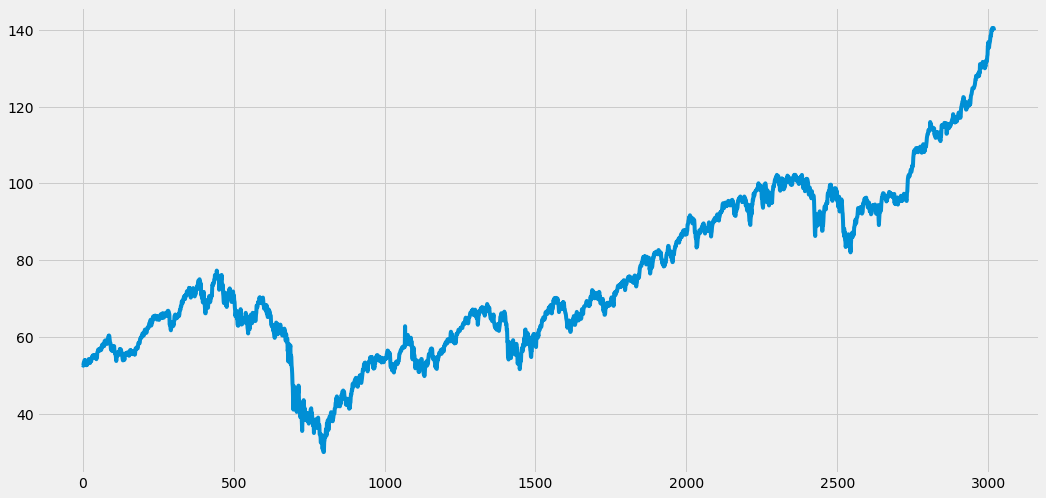

In [185]:
#plot
plt.figure(figsize=(16,8))
plt.plot(data['Close'], label='Close Price history')

In [186]:
rolling_mean = data.rolling(window=365).mean()
rolling_std = data.rolling(window=365).std()


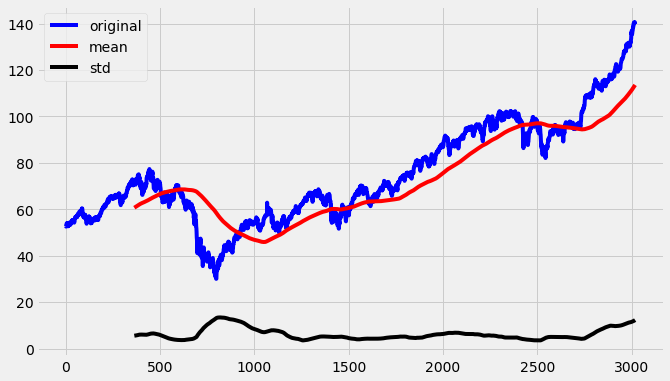

In [205]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
orig = plt.plot(data.Close, color ='blue',label='original')
mean = plt.plot(rolling_mean, color ='red',label='mean')
std = plt.plot(rolling_std, color ='black',label='std')
plt.legend(loc='best')
plt.show()

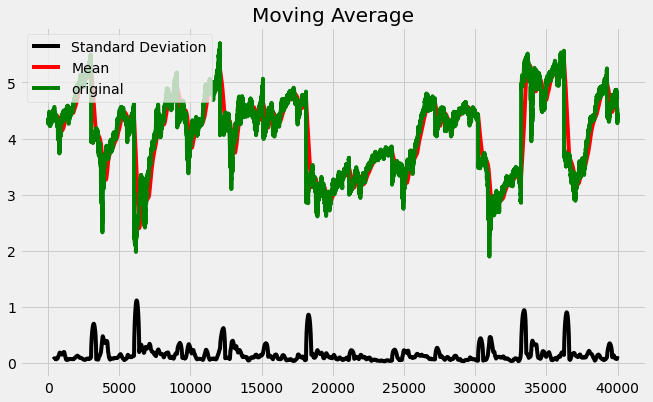

In [204]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df.Close)
moving_avg = df_log.rolling(365).mean()
std_dev = df_log.rolling(365).std()
plt.legend(loc='upper left')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.plot(df_log, color="green", label = "original")
plt.legend(loc='upper left')
plt.show()

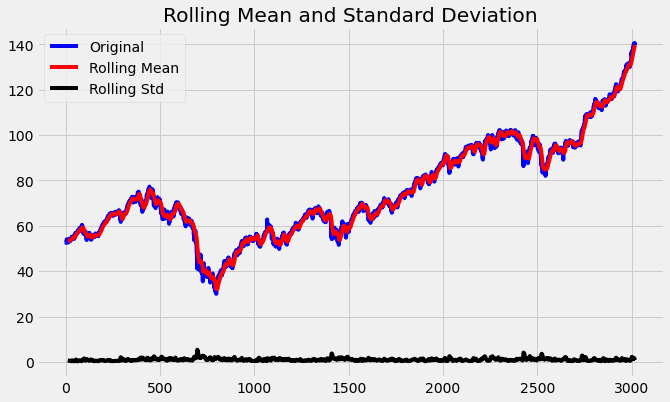

Results of dickey fuller test
Test Statistics                   1.167858
p-value                           0.995756
No. of lags used                 18.000000
Number of observations used    3001.000000
critical value (1%)              -3.432531
critical value (5%)              -2.862504
critical value (10%)             -2.567283
dtype: float64


In [202]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(data.Close)

<Figure size 720x432 with 0 Axes>

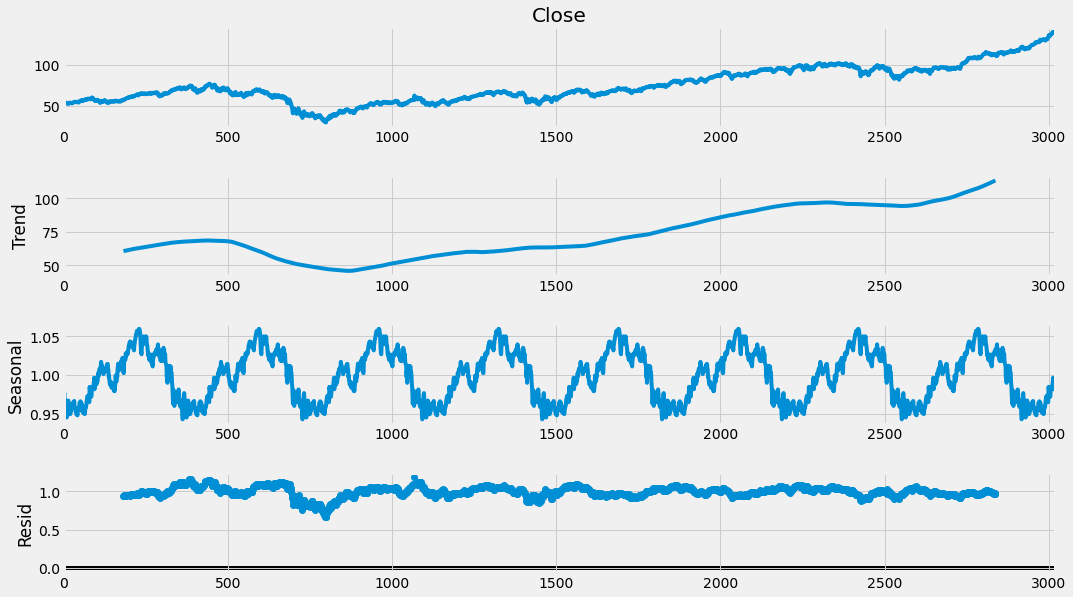

In [203]:
result = seasonal_decompose(data.Close, model='multiplicative', freq = 365)
fig = plt.figure() 
fig = result.plot()  
fig.set_size_inches(16, 9)

In [191]:
"""

to develop a model that could capture seasonality in time-series data, 
Facebook developed the famous Prophet model that is publicly available for everyone.

"""

'\nto develop a model that could capture seasonality in time-series data, \nFacebook developed the famous Prophet model that is publicly available for everyone.\n'

In [192]:
len(data)

3020

In [175]:
#importing prophet
from fbprophet import Prophet

# #creating dataframe
new_data = pd.DataFrame(index=range(0,len(data)),columns=['Date', 'Close'])

for i in range(0,len(train)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

new_data['Date'] = pd.to_datetime(data.Date,format='%Y-%m-%d')
new_data.index = new_data['Date']

#preparing data
"""
Prophet requires the variable names in the time series to be:

y – Target
ds – Datetime
"""
new_data.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)

#train and validation
train = new_data[:2900]
valid = new_data[2900:]

#fit the model
model = Prophet()
model.fit(train)



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [176]:
#predictions
close_prices = model.make_future_dataframe(periods=len(valid))
forecast = model.predict(close_prices)

In [177]:
close_prices.head()

,ds
0,2006-01-03
1,2006-01-04
2,2006-01-05
3,2006-01-06
4,2006-01-09


In [178]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2006-01-03,51.869804,47.781351,57.447520,51.869804,51.869804,0.588852,0.588852,0.588852,-0.015642,-0.015642,-0.015642,0.604494,0.604494,0.604494,0.0,0.0,0.0,52.458656
1,2006-01-04,51.903118,47.064935,57.247188,51.903118,51.903118,0.566463,0.566463,0.566463,-0.018564,-0.018564,-0.018564,0.585027,0.585027,0.585027,0.0,0.0,0.0,52.469580
2,2006-01-05,51.936431,47.460832,57.439988,51.936431,51.936431,0.559531,0.559531,0.559531,0.003432,0.003432,0.003432,0.556098,0.556098,0.556098,0.0,0.0,0.0,52.495961
3,2006-01-06,51.969744,47.287688,57.138067,51.969744,51.969744,0.492680,0.492680,0.492680,-0.024692,-0.024692,-0.024692,0.517372,0.517372,0.517372,0.0,0.0,0.0,52.462424
4,2006-01-09,52.069684,47.546418,57.049715,52.069684,52.069684,0.295167,0.295167,0.295167,-0.047214,-0.047214,-0.047214,0.342382,0.342382,0.342382,0.0,0.0,0.0,52.364851


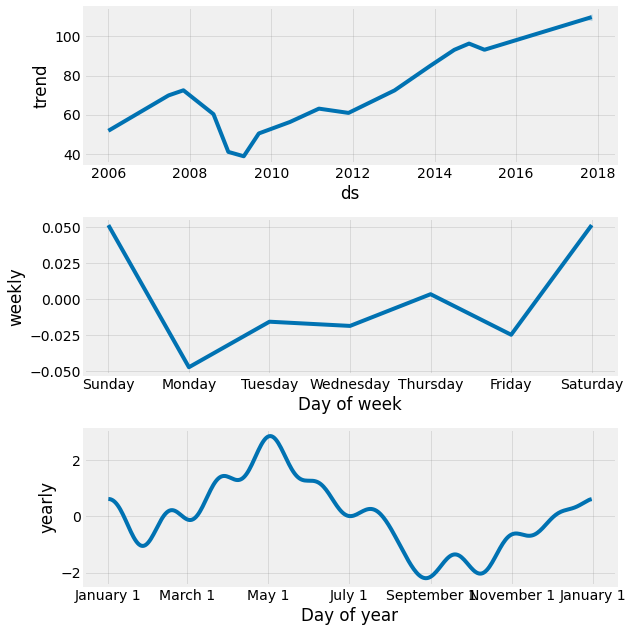

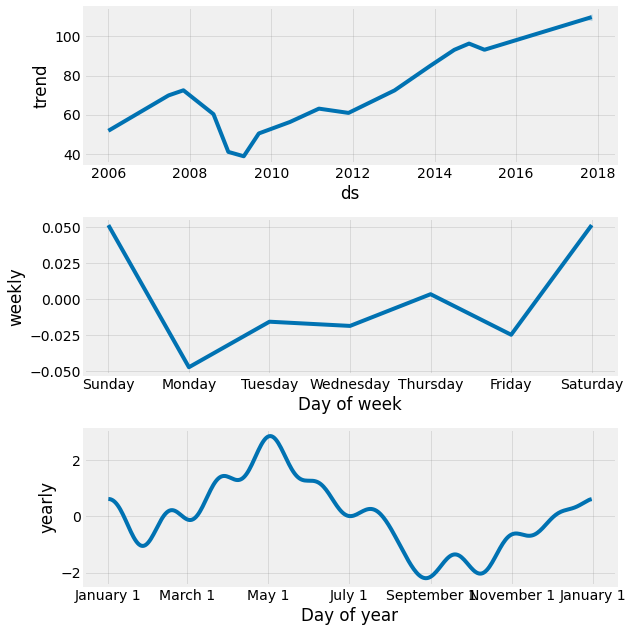

In [179]:
model.plot_components(forecast)

In [170]:
sub = pd.DataFrame()

In [171]:
new_test = pd.DataFrame()
new_test['ds'] = test['Date']

In [172]:
new_test

,ds
0,2011-01-01
1,2011-01-02
2,2011-01-03
3,2011-01-04
4,2011-01-05
...,...
2550,2017-12-25
2551,2017-12-26
2552,2017-12-27
2553,2017-12-28


In [173]:
sub['Date']=test['Date']
sub['Close']=model.predict(new_test)['yhat']

In [91]:
sub.to_csv('prophet_3.csv',index=False)